# CharityML project by Sumit Popli

## Adding pre-requiste python packages
## These packages are required for processing input data/running
## Classifying entries in to earning above 50K  using different ML classification techniques
##  model evaluation
## model tuning
##  visualizations

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,fbeta_score,precision_score,recall_score,confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#classifiers
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.ensemble import AdaBoostClassifier as abc
from sklearn.ensemble import GradientBoostingClassifier as gbc

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## pre-processing function to encode and scale data

In [6]:
'''
hot encode the following:
workclass[1], marital-status[4],occupation[5]
race[7], sex[8], native-country[12]
scale age, hoursperweek, capital-gains and capital-loss

removing education and retaining education num as they have the same information

simplifying marital-status and family columns

encode income column
'''
def pre_process_data(profiledata, income):

   #removing column education-level from profiledata as education-num has the same information
   profiledata = profiledata.drop([2], axis=1)

   #marital status and family are columns that provide the same information
   #processing both columns to simplify data
   profiledata['married'] = np.where(((profiledata[6] == 'Husband') | (profiledata[6] == 'Wife')), 1, 0)

   #dropping relationship and marital status from profile data
   profiledata = profiledata.drop([6], axis=1)
   profiledata = profiledata.drop([4], axis=1)

   # scaling all the higher and lower values
   std_scaler = StandardScaler()
   profiledata.iloc[:, [0, 2, 6, 7, 8]] = std_scaler.fit_transform(profiledata.iloc[:, [0, 2, 6, 7, 8]])

   #encoding all the categorical data
   profiledata =  pd.get_dummies(profiledata, prefix=['workclass','occupation','race', 'sex', 'native-country'], columns=[1,5,7,8,12])

   #scaled and encoded all the reqd fields. removing dummy variable trap: one column for sex will suffice.
   #dropping sex_male column
   profiledata = profiledata.drop(['sex_ Male'], axis=1)
   profiledata = profiledata.interpolate()

   if(income is None):
       return profiledata, None

   #encoding income column
   income = pd.get_dummies(income,prefix='income',columns=[0])
   #removing <50k column as one column will suffice
   income = income.drop(['income_<=50K'], axis=1)
   #changing the header name back to 'income'
   income.rename(columns={'income_>50K':'income'}, inplace=True)


   return profiledata,income

## analysing data to get insights. Slice data using pandas to see which features play an important role in salary above 50K

In [7]:
#find out how many earn above 50K.
#find out stats about education and earnings
#find out age and earnings
#find out working hrs and earnings
#find out profession and earnings
#find out marital status and earnings
#find out capital gains and earnings

def data_insights(censusdata):


    #finding how many and % of people donating
    earn_50k = censusdata.loc[censusdata[13] == '>50K']
    print('========================================')
    print('no of people donating vs total no of people is {0}/{1}'.format(earn_50k.shape[0], censusdata.shape[0]))
    print('% of people donating is {0}'.format(earn_50k.shape[0]*100/censusdata.shape[0]))
    print('========================================')

    #finding out stats of how many people with higher degree donate
    high_degree = censusdata.loc[(censusdata[3] >= 13) & (censusdata[13] == '>50K')]
    print('========================================')
    print('no of people with high degree donating is {0}'.format(high_degree.shape[0]))
    print('% of people donating that have high degree is {0}'.format(high_degree.shape[0]*100/earn_50k.shape[0]))
    print('========================================')

    #finding out stats for people above certain age that donate
    high_age = censusdata.loc[(censusdata[0]>=40) & (censusdata[13]=='>50K')]
    print('========================================')
    print('no of people with high age donating is {0}'.format(high_age.shape[0]))
    print('% of people donating that have high age is {0}'.format(high_age.shape[0] * 100 / earn_50k.shape[0]))
    print('========================================')

    #finding out stats for people working normal and higher hours that donate
    high_workhrs = censusdata.loc[(censusdata[11]>=40) & (censusdata[13]=='>50K')]
    print('========================================')
    print('no of people with normal and high working hrs donating is {0}'.format(high_workhrs.shape[0]))
    print('% of people donating that have high age is {0}'.format(high_workhrs.shape[0] * 100 / earn_50k.shape[0]))
    print('========================================')

    #finding out stats for people working in professional jobs
    pro_jobs = censusdata.loc[((censusdata[5]=='Prof-specialty')|(censusdata[5]=='Exec-managerial')) & (censusdata[13]=='>50K')]
    print('========================================')
    print('no of people with professional jobs donating is {0}'.format(pro_jobs.shape[0]))
    print('% of people donating that have professional jobs is {0}'.format(pro_jobs.shape[0] * 100 / earn_50k.shape[0]))
    print('========================================')

    #finding out stats for people who are married
    marital_status = censusdata.loc[((censusdata[6] == 'Husband') | (censusdata[6] == 'Wife')) & (censusdata[13] == '>50K')]
    print('========================================')
    print('no of people with marital status married donating is {0}'.format(marital_status.shape[0]))
    print('% of people donating that have marital status married is {0}'.format(marital_status.shape[0] * 100 / earn_50k.shape[0]))
    print('========================================')

    #finding out stats for people who have capital gains and donate
    cap_gains = censusdata.loc[(censusdata[9] > 0) & (censusdata[13] == '>50K')]
    print('========================================')
    print('no of people with capital gains donating is {0}'.format(cap_gains.shape[0]))
    print('% of people donating with capital gains is {0}'.format(cap_gains.shape[0] * 100 / earn_50k.shape[0]))
    print('========================================')

## accessing the census.csv file to seperate the target variable from features.
## calling functions to get data insights to see which features are important, which features need to be combined or dropped
## processing Pandas dataframe to encode and scale all variables. 
## calling different classifier models 



In [8]:
    #read the csv file in to pandas
    people_data = pd.read_csv('census.csv',header=None, skiprows=1)

    #cleaning up occupation column data for insights
    people_data[5] = people_data[5].str.strip()
    people_data[6]= people_data[6].str.strip()
    print("no of rows {0}".format(people_data.shape[0]))
    data_insights(people_data)

    #seperate the features from the independent feature
    X = people_data.iloc[:,0:13]
    y = people_data.iloc[:,13]
    processed_X, processed_y = pre_process_data(X,y)

    X_train = processed_X
    y_train = processed_y
    print(X_train.head())

    test_people_data = pd.read_csv('test_census.csv',header=None, skiprows=1)
    print("no of rows {0}".format(test_people_data.shape[0]))
    X_test = test_people_data.iloc[:,1:14]
    #reindexing all the columns after the drop
    X_test.columns = range(X_test.shape[1])

    # cleaning up occupation column data for insights
    X_test[5] = X_test[5].str.strip()
    X_test[6] = X_test[6].str.strip()
    processed_X_test, temp = pre_process_data(X_test, None)

no of rows 45222
no of people donating vs total no of people is 11208/45222
% of people donating is 24.78439697492371
no of people with high degree donating is 5562
% of people donating that have high degree is 49.62526766595289
no of people with high age donating is 7121
% of people donating that have high age is 63.534975017844395
no of people with normal and high working hrs donating is 10234
% of people donating that have high age is 91.30977872947895
no of people with professional jobs donating is 5571
% of people donating that have professional jobs is 49.70556745182013
no of people with marital status married donating is 9523
% of people donating that have marital status married is 84.96609564596717
no of people with capital gains donating is 2375
% of people donating with capital gains is 21.190221270521057
          0         3         9       10        11  married  \
0  0.034201  1.128753  0.142888 -0.21878 -0.078120        0   
1  0.866417  1.128753 -0.146733 -0.21878 -2.326

## implementing model evaluation function. This function calculates:
## accuracy_score (to see how many values did we get right)
## Precision (to see how many values predicted as above 50K were actually above 50K)
## recall (to see out of all the people above 50K how many were correctly predicted)
## f1 score (combination of Precision and recall. Gives good indication of how good the model is)
## fbeta (score that indicates how good our precision values are)
## ROC and ROC_auc score. Another indicator of how well our model performs. The visual indication helps the user as well.


In [9]:
def model_performance_metrics(modelname, y_true, y_pred):
    ac = accuracy_score(y_true, y_pred)
    ps = precision_score(y_true, y_pred)
    rs = recall_score(y_true, y_pred)
    f1_s = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    fb_4 = fbeta_score(y_true, y_pred,0.4)


    print('+++++++++++++++++++++++++++++++')
    print('accuracy score:{0}, precision score: {1}, recall score: {2} , f1 score {3}, f0.4 score {4} for {5}'.format(ac, ps, rs, f1_s,fb_4, modelname))
    print('+++++++++++++++++++++++++++++++')

    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_true,y_pred)
    print('roc_auc_score for {0}: {1} '.format(modelname, roc_auc_score(y_true,y_pred)) )


    # Plot ROC curves
    plt.subplots(1, figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## implementing decision tree classifier function. This function does the following:
## uses GridSearchCV to pick the best hyper-parameter value for DTC
## runs the model with different combinations
## outputs the best hyper-parament combo for best results
## lists out feature importance
## removes the columns that are not important 
## runs the model on the data again. 
## prints out model performance


In [10]:
#Decision Tree Classifier
def donation_dtc(X, y, test_data):


    parameters = {'criterion': ['gini', 'entropy'], 'max_depth': [8, 10,12,15], 'min_samples_split': [2, 4, 8, 10],'min_samples_leaf': [2, 4, 6, 8, 10]}
    scorer = make_scorer(f1_score)

    model = dtc(random_state=13)
    grid_obj = GridSearchCV(model, parameters, scoring=scorer)
    grid_fit = grid_obj.fit(X, y)

    best_model_params = grid_fit.best_estimator_
    print('best clf is {0}'.format(best_model_params) )
    #print('model feature importance: {0}'.format(best_model_params.feature_importances_))
    print(dict(zip(X.columns, best_model_params.feature_importances_)))
    y_pred = best_model_params.predict(X)
    #model_performance_metrics('decision tree classifier (whole training data)', y, y_pred)

    model_best = SelectFromModel(best_model_params, prefit=True)
    X_new = model_best.transform(X)
    print('old Shape of X is {0}'.format(X.shape))
    print('new Shape of X is {0}'.format(X_new.shape))


    #splitting the training data further to test the model
    Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_new,y, test_size=.25, random_state=13)
    start_dt = dt.datetime.now()
    modelv2 = dtc(criterion='entropy',max_depth=15, min_samples_leaf=2, min_samples_split=10, splitter='best', random_state=13)
    modelv2.fit(Xt_train, yt_train)
    yt_pred = modelv2.predict(Xt_test)
    end_dt = dt.datetime.now()
    model_performance_metrics('decision tree classifier (split training data)', yt_test, yt_pred)
    delta_dt = end_dt - start_dt
    print('time taken (in seconds) for dtc is {0}'.format(delta_dt.total_seconds()))

    #now testing against actual data
    test_data_new = model_best.transform(test_data)
    y_test = modelv2.predict(test_data_new)
    return y_test

## implementing Random Tree classifier function. This function does the following:
## uses GridSearchCV to pick the best hyper-parameter value for rfc
## runs the model with different combinations
## outputs the best hyper-parament combo for best results
## lists out feature importance
## removes the columns that are not important 
## runs the model on the data again. 
## prints out model performance

In [11]:
#Random Forest Classifier
def donation_rfc(X, y, test_data):

    parameters = {'criterion': ['gini', 'entropy'], 'max_depth': [12, 15,18,20,22], 'min_samples_split': [4, 8, 10],
                  'min_samples_leaf': [4, 6, 8, 10],'n_estimators': [50, 100, 150]}
    scorer = make_scorer(f1_score)

    model = rfc(random_state=13)
    grid_obj = GridSearchCV(model, parameters, scoring=scorer)
    grid_fit = grid_obj.fit(X, y.values.ravel())

    best_model_params = grid_fit.best_estimator_
    print('best clf is {0}'.format(best_model_params))
    # print('model feature importance: {0}'.format(best_model_params.feature_importances_))
    print(dict(zip(X.columns, best_model_params.feature_importances_)))
    y_pred = best_model_params.predict(X)
    #model_performance_metrics('random forest classifier (whole training data)', y, y_pred)

    model_best = SelectFromModel(best_model_params, prefit=True)
    X_new = model_best.transform(X)
    print('old Shape of X is {0}'.format(X.shape))
    print('new Shape of X is {0}'.format(X_new.shape))

    #splitting the training data further to test the model
    Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_new,y, test_size=.25, random_state=13)
    start_dt = dt.datetime.now()
    modelv2 = rfc(bootstrap=True, criterion='entropy', max_depth=20,max_features='auto', min_samples_leaf= 4, min_samples_split= 4, n_estimators= 150, warm_start= False, oob_score= False ,random_state=13)
    modelv2.fit(Xt_train, yt_train.values.ravel())
    yt_pred = modelv2.predict(Xt_test)
    end_dt = dt.datetime.now()
    model_performance_metrics('random forest classifier (split train data)',yt_test, yt_pred)
    delta_dt = end_dt - start_dt
    print('time taken (in seconds) for rfc is {0}'.format(delta_dt.total_seconds()))

    # now testing against actual data
    test_data_new = model_best.transform(test_data)
    y_test = modelv2.predict(test_data_new)
    return y_test


## implementing Ada boost classifier function. This function does the following:
## uses GridSearchCV to pick the best hyper-parameter value for abc
## runs the model with different combinations
## outputs the best hyper-parament combo for best results
## lists out feature importance
## removes the columns that are not important 
## runs the model on the data again. 
## prints out model performance

In [12]:
#ada boost classifier
def donation_abc(X, y, test_data):
    #setting up hyper parameter
    parameters = {'learning_rate': [0.2,0.5,1], 'algorithm': ['SAMME', 'SAMME.R'],'n_estimators': [75, 100, 150]}
    scorer = make_scorer(f1_score)

    base_model = dtc(min_samples_leaf=2, min_samples_split=10,criterion='entropy',max_depth=15)
    model = abc(base_estimator = base_model,random_state=13)
    # taking the training data and fitting in to the model
    grid_obj = GridSearchCV(model, parameters, scoring=scorer)
    grid_fit = grid_obj.fit(X, y.values.ravel())

    best_model_params = grid_fit.best_estimator_
    print('best clf is {0}'.format(best_model_params))
    # print('model feature importance: {0}'.format(best_model_params.feature_importances_))
    print(dict(zip(X.columns, best_model_params.feature_importances_)))
    y_pred = best_model_params.predict(X)
    #model_performance_metrics('ada boost classifier (whole training data)',y, y_pred)

    model_best = SelectFromModel(best_model_params, prefit=True)
    X_new = model_best.transform(X)
    print('old Shape of X is {0}'.format(X.shape))
    print('new Shape of X is {0}'.format(X_new.shape))

    # splitting the training data further to test the model
    Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_new, y, test_size=.25, random_state=13)

    start_dt = dt.datetime.now()
    modelv2 = abc(algorithm='SAMME',base_estimator=dtc(ccp_alpha=0.0,class_weight=None,criterion='entropy',max_depth=15,max_features=None,max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=2,min_samples_split=10,min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',random_state=None,splitter='best'),learning_rate=0.2, n_estimators=150, random_state=13)
    # taking the training data and fitting in to the model
    modelv2.fit(Xt_train, yt_train.values.ravel())
    yt_pred = modelv2.predict(Xt_test)
    end_dt = dt.datetime.now()
    model_performance_metrics('ada boost classifier (split train data)',yt_test,yt_pred)
    delta_dt = end_dt - start_dt
    print('time taken (in seconds) for abc in minutes is {0}'.format(delta_dt.total_seconds()))

    # now testing against actual data
    test_data_new = model_best.transform(test_data)
    y_test = modelv2.predict(test_data_new)
    return y_test

## svc classifier. 

In [13]:
def donation_svc(X, y, test_data):

    #splitting the training data further to test the model
    Xt_train, Xt_test, yt_train, yt_test = train_test_split(X,y, test_size=.25, random_state=13)
    start_dt = dt.datetime.now()
    modelv2 = SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf', max_iter=-1, probability=False, random_state=13, shrinking=True, tol=0.001, verbose=False)
    modelv2.fit(Xt_train, yt_train.values.ravel())
    yt_pred = modelv2.predict(Xt_test)
    end_dt = dt.datetime.now()
    model_performance_metrics('support vector classifier (split training data)', yt_test, yt_pred)
    delta_dt = end_dt - start_dt
    print('time taken (in seconds) for svc is {0}'.format(delta_dt.total_seconds()))

    # now testing against actual data
    y_test = modelv2.predict(test_data)
    return y_test

## calling different classifier functions to check which one is the best. 

best clf is DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13, splitter='best')
{0: 0.0870174323725636, 'native-country_ Columbia': 0.0, 'race_ Black': 0.0033311835332087113, 3: 0.17562022721619885, 'native-country_ Laos': 0.0, 'occupation_Other-service': 0.005478081439078272, 'native-country_ Italy': 0.0, 'native-country_ Guatemala': 0.0, 'occupation_Handlers-cleaners': 0.0010775053125431343, 9: 0.1806614884579773, 10: 0.06588230280244227, 11: 0.0511257861680008, 'native-country_ Vietnam': 0.0, 'occupation_Transport-moving': 0.0008163227980634596, 'occupation_Tech-support': 0.0019106602761239573, 'workclass_ Private': 0.003771049615

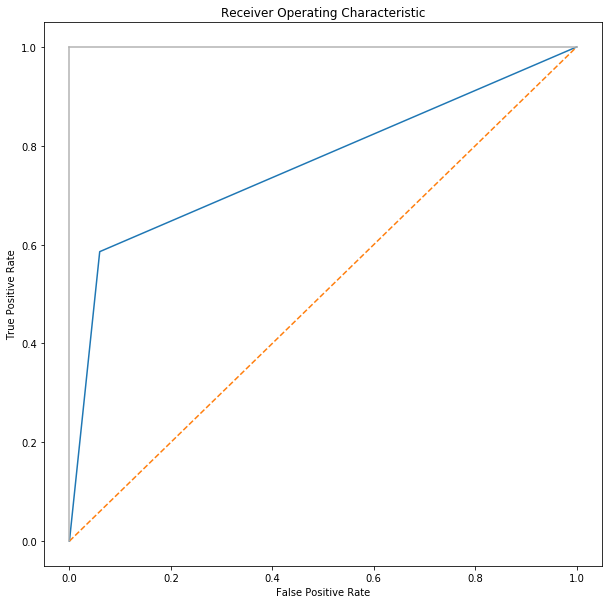

time taken (in seconds) for dtc is 0.050607
best clf is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)
{0: 0.14426764271996664, 'native-country_ Columbia': 0.0001564896834183211, 'race_ Black': 0.004388670977584067, 3: 0.12231089542653034, 'native-country_ Laos': 9.538854210322494e-06, 'occupation_Other-service': 0.0230499052615876, 'native-country_ Italy': 0.0001033974042709321, 'native-country_ Guatemala': 0.00011143295935554992, 'occupation_Handlers-cleaners': 0.007044364551199224, 9: 0.160171

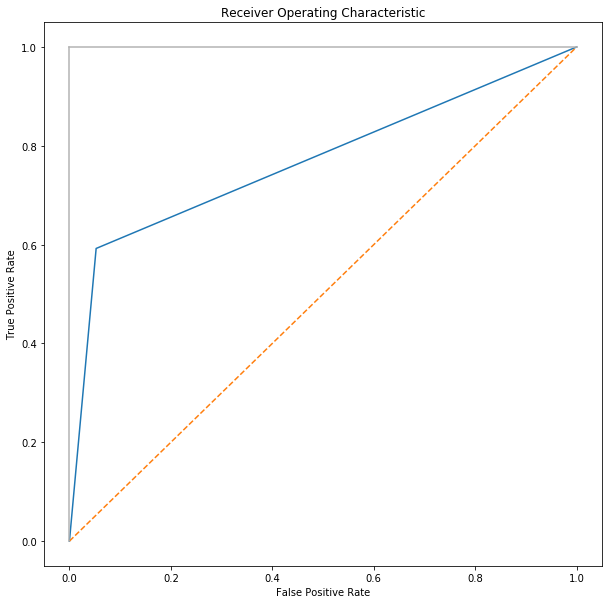

time taken (in seconds) for rfc is 3.256368
+++++++++++++++++++++++++++++++
accuracy score:0.8561825579338405, precision score: 0.7622950819672131, recall score: 0.6025917926565875 , f1 score 0.6731001206272618, f0.4 score 0.7354117433193966 for support vector classifier (split training data)
+++++++++++++++++++++++++++++++
roc_auc_score for support vector classifier (split training data): 0.7706908306622524 


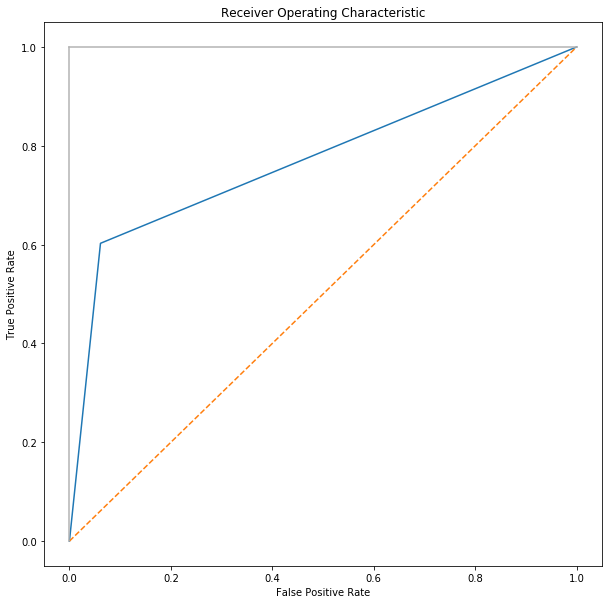

time taken (in seconds) for svc is 108.829463
best clf is AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=15,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=10,
                                                         min_weight_fraction_leaf=0.0,
                                            

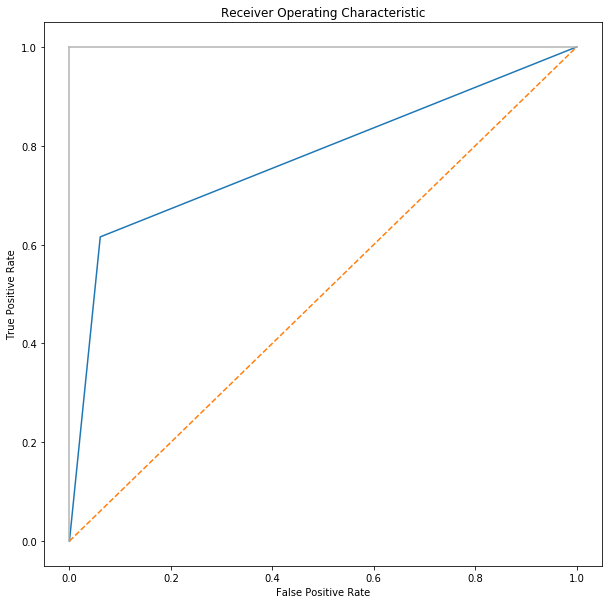

time taken (in seconds) for abc in minutes is 9.637713


In [17]:
    test_result_index_col = np.asarray(test_people_data.iloc[:, 0])
    test_result_index_col = test_result_index_col.reshape(-1, 1)

    dtc_income_data = donation_dtc(X_train, y_train, processed_X_test)
    dtc_income_data = dtc_income_data.reshape(-1,1)
    dtc_test_score = np.append(test_result_index_col, dtc_income_data,axis=1)
    np.savetxt('dtc_results.csv', dtc_test_score, delimiter=',')
    
    rfc_income_data = donation_rfc(X_train, y_train, processed_X_test)
    rfc_income_data = rfc_income_data.reshape(-1, 1)
    rfc_test_score = np.append(test_result_index_col, rfc_income_data, axis=1)
    np.savetxt('rfc_results.csv', rfc_test_score, delimiter=',')

    svc_income_data = donation_svc(X_train, y_train, processed_X_test)
    svc_income_data = svc_income_data.reshape(-1,1)
    svc_test_score = np.append(test_result_index_col, svc_income_data, axis=1)
    np.savetxt('svc_results.csv', svc_test_score, delimiter=',')

    abc_income_data = donation_abc(X_train, y_train, processed_X_test)
    abc_income_data = abc_income_data.reshape(-1, 1)
    abc_test_score = np.append(test_result_index_col, abc_income_data, axis=1)
    np.savetxt('abc_results.csv', abc_test_score, delimiter=',')

## model score comparison with focus on ROC_auc_score/F1 score and precision score

###decision tree classifier
+++++++++++++++++++++++++++++++
accuracy score:0.8531753051477092, precision score: 0.7617041198501873, recall score: 0.5856731461483081 , f1 score 0.6621896621896621, f0.4 score 0.731383308531746 for decision tree classifier (split training data)
+++++++++++++++++++++++++++++++
roc_auc_score for decision tree classifier (split training data): 0.7629937025300639 

Random forest classifier
+++++++++++++++++++++++++++++++
accuracy score:0.8600742968335398, precision score: 0.7855778414517669, recall score: 0.5921526277897768 , f1 score 0.675287356321839, f0.4 score 0.7517096845356277 for random forest classifier (split train data)
+++++++++++++++++++++++++++++++
roc_auc_score for random forest classifier (split train data): 0.7697512669905733

SVC 
+++++++++++++++++++++++++++++++
accuracy score:0.8561825579338405, precision score: 0.7622950819672131, recall score: 0.6025917926565875 , f1 score 0.6731001206272618, f0.4 score 0.7354117433193966 for support vector classifier (split training data)
+++++++++++++++++++++++++++++++
roc_auc_score for support vector classifier (split training data): 0.7706908306622524 

AdaBoostClassifier
accuracy score:0.8597205023881125, precision score: 0.7675044883303411, recall score: 0.6155507559395248 , f1 score 0.6831801837794647, f0.4 score 0.7422319343830449 for ada boost classifier (split train data)
+++++++++++++++++++++++++++++++
roc_auc_score for ada boost classifier (split train data): 0.7774048338797062 


##conclusion
AdaBoost classifier is the best model (by a small margin) as the f1 score, ROC score are better than other models.